# Training of a simple encoder transformer
- trained with a small balanced dataset 

In [2]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn

print(torch.__version__)

notebook_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(notebook_dir, "../../.."))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)
    
MODEL_V = "04_simple_transformer"

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

2.2.2
/Users/damianstone/Documents/Code/machine-learning/dl-sepsis-prediction


device(type='cpu')

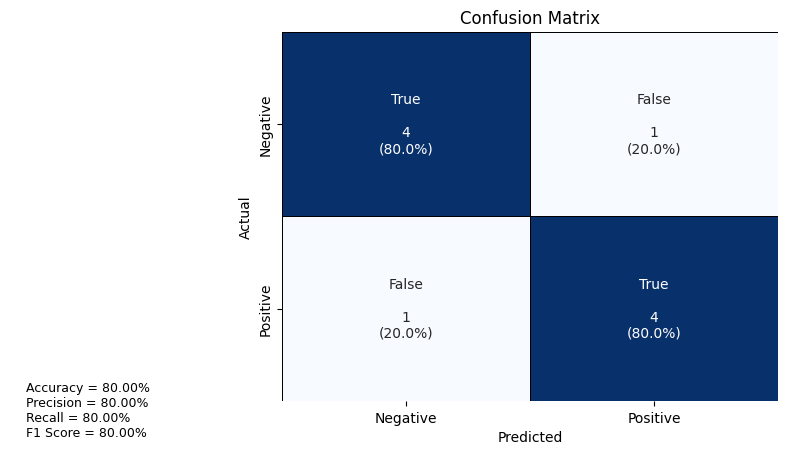

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix with counts, percentages, and summary statistics.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        class_names (list): List of class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)

    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = f"True\n\n{c}\n({p:.1f}%)"
            else:
                s = f"False\n\n{c}\n({p:.1f}%)"
            annot[i, j] = s

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=annot, fmt='', cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')

    # Summary statistics
    accuracy = np.trace(cm) / float(np.sum(cm))
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    stats_text = f"""
    Accuracy = {accuracy:.2%}
    Precision = {precision:.2%}
    Recall = {recall:.2%}
    F1 Score = {f1:.2%}
    """
    plt.gcf().text(-0.3, 0, stats_text, fontsize=9, va="bottom")

    plt.show()

# Example usage
y_true = [0, 1, 0, 1, 0, 1, 1, 0, 0, 1]
y_pred = [0, 0, 0, 1, 0, 1, 1, 0, 1, 1]
class_names = ['Negative', 'Positive']
plot_confusion_matrix(y_true, y_pred, class_names)


## Splitting the data

In [13]:
from Dataset import Dataset

data_loader = Dataset(
    data_path="Fully_imputed_dataset.parquet",
    save_path="dataset_tensors.pth",
    method="oversample",
    balance=True,
    minority_ratio=0.3,
    target_column="SepsisLabel"
)

In [14]:
# as tensors
X_train, X_test, y_train, y_test = data_loader.get_train_test_tensors(size='small', sample_fraction=0.1)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

Patient-level balance statistics:
Total patients: 53434
Label 0: 37404 patients (70.00%)
Label 1: 16030 patients (30.00%)
Imbalance ratio (majority/minority): 2.33
Negative-to-positive ratio (per patient): 2.33337492202121
Total records in reduced training set: 184542


## Transformer architecture

In [15]:
from architectures import TransformerClassifier


in_dim = X_train.shape[1]
model = TransformerClassifier(input_dim=in_dim)

In [16]:
from torch.utils.data import DataLoader, TensorDataset


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 512 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Training loop

In [26]:
from tqdm import tqdm
from torchmetrics import Accuracy, Precision, Recall
from torchvision.ops import sigmoid_focal_loss
from torch import nn


model = TransformerClassifier(input_dim=in_dim).to(device)
pos_weight = torch.tensor([2.3], dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) 

epochs = 100
epoch_counter = []
loss_counter = []
acc_counter = []

t_accuracy = Accuracy(task='binary').to(device)
t_precision = Precision(task='binary').to(device)
t_recall = Recall(task='binary').to(device)

for epoch in range(epochs):
    model.train()
    epoch_loss, epoch_acc, epoch_prec, epoch_rec = 0, 0, 0, 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # forward pass
        y_logits = model(X_batch)
        # print("Logits sample:", y_logits[:5].detach().cpu().numpy())  # Should have positive values too
        y_probs = torch.sigmoid(y_logits)
        # because the dataset is too imbalance
        y_preds = (y_probs >= 0.3).float() 

        # loss function
        loss = loss_fn(y_logits, y_batch.unsqueeze(1).float())
        
        acc = t_accuracy(y_preds, y_batch.unsqueeze(1).float())
        prec = t_precision(y_preds, y_batch.unsqueeze(1).float())
        rec = t_recall(y_preds, y_batch.unsqueeze(1).float())
        
        # zero grad
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        # optimizer
        optimizer.step()

        # update epoch metrics
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_prec += prec
        epoch_rec += rec
        
        progress_bar.set_postfix({"Loss": loss.item(), "Acc": acc.item(), "Prec": prec.item(), "Rec": rec.item()})

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    epoch_prec /= len(train_loader)
    epoch_rec /= len(train_loader)
    acc_counter.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.5f} | Accuracy: {epoch_acc:.2f}% | Precision: {epoch_prec:.2f}% | Recall: {epoch_rec:.2f}%")

Epoch 1/100:   0%|          | 0/361 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.354, Acc=0.91, Prec=0.25, Rec=0.333]    

Epoch 1/100 | Loss: 0.43422 | Accuracy: 0.92% | Precision: 0.07% | Recall: 0.04%


Epoch 2/100 | Loss: 0.42555 | Accuracy: 0.91% | Precision: 0.15% | Recall: 0.07%


Epoch 3/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.325, Acc=0.941, Prec=0, Rec=0]          

Epoch 3/100 | Loss: 0.42135 | Accuracy: 0.91% | Precision: 0.19% | Recall: 0.10%


Epoch 4/100 | Loss: 0.41723 | Accuracy: 0.90% | Precision: 0.19% | Recall: 0.12%


Epoch 5/100:   0%|          | 0/361 [00:32<?, ?it/s, Loss=0.361, Acc=0.932, Prec=0.2, Rec=0.0833]   

Epoch 5/100 | Loss: 0.41411 | Accuracy: 0.90% | Precision: 0.20% | Recall: 0.15%


Epoch 6/100 | Loss: 0.41195 | Accuracy: 0.90% | Precision: 0.21% | Recall: 0.15%


Epoch 7/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.35, Acc=0.914, Prec=0.2, Rec=0.154]     

Epoch 7/100 | Loss: 0.41049 | Accuracy: 0.90% | Precision: 0.21% | Recall: 0.16%


Epoch 8/100 | Loss: 0.40595 | Accuracy: 0.90% | Precision: 0.21% | Recall: 0.19%


Epoch 9/100:   0%|          | 0/361 [00:31<?, ?it/s, Loss=0.447, Acc=0.86, Prec=0.136, Rec=0.2]     

Epoch 9/100 | Loss: 0.40098 | Accuracy: 0.90% | Precision: 0.22% | Recall: 0.21%


Epoch 10/100 | Loss: 0.39650 | Accuracy: 0.89% | Precision: 0.23% | Recall: 0.25%


Epoch 11/100:   0%|          | 0/361 [00:31<?, ?it/s, Loss=0.383, Acc=0.892, Prec=0.154, Rec=0.133]  

Epoch 11/100 | Loss: 0.39068 | Accuracy: 0.90% | Precision: 0.25% | Recall: 0.26%


Epoch 12/100 | Loss: 0.38413 | Accuracy: 0.90% | Precision: 0.26% | Recall: 0.30%


Epoch 13/100:   0%|          | 0/361 [00:26<?, ?it/s, Loss=0.363, Acc=0.901, Prec=0.3, Rec=0.429]   

Epoch 13/100 | Loss: 0.37661 | Accuracy: 0.90% | Precision: 0.27% | Recall: 0.32%


Epoch 14/100 | Loss: 0.36965 | Accuracy: 0.90% | Precision: 0.28% | Recall: 0.34%


Epoch 15/100:   0%|          | 0/361 [00:26<?, ?it/s, Loss=0.457, Acc=0.887, Prec=0.429, Rec=0.409] 

Epoch 15/100 | Loss: 0.36174 | Accuracy: 0.89% | Precision: 0.28% | Recall: 0.37%


Epoch 16/100 | Loss: 0.35361 | Accuracy: 0.90% | Precision: 0.30% | Recall: 0.39%


Epoch 17/100:   0%|          | 0/361 [00:29<?, ?it/s, Loss=0.343, Acc=0.932, Prec=0.667, Rec=0.571]

Epoch 17/100 | Loss: 0.34441 | Accuracy: 0.90% | Precision: 0.31% | Recall: 0.42%


Epoch 18/100 | Loss: 0.33654 | Accuracy: 0.90% | Precision: 0.31% | Recall: 0.44%


Epoch 19/100:   0%|          | 0/361 [00:29<?, ?it/s, Loss=0.308, Acc=0.892, Prec=0.32, Rec=0.533] 

Epoch 19/100 | Loss: 0.32820 | Accuracy: 0.90% | Precision: 0.32% | Recall: 0.47%


Epoch 20/100 | Loss: 0.32044 | Accuracy: 0.90% | Precision: 0.33% | Recall: 0.49%


Epoch 21/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.217, Acc=0.905, Prec=0.238, Rec=0.5]  

Epoch 21/100 | Loss: 0.31282 | Accuracy: 0.90% | Precision: 0.34% | Recall: 0.51%


Epoch 22/100 | Loss: 0.30382 | Accuracy: 0.90% | Precision: 0.34% | Recall: 0.54%


Epoch 23/100:   0%|          | 0/361 [00:34<?, ?it/s, Loss=0.263, Acc=0.928, Prec=0.455, Rec=0.714]

Epoch 23/100 | Loss: 0.29669 | Accuracy: 0.90% | Precision: 0.35% | Recall: 0.56%


Epoch 24/100 | Loss: 0.28907 | Accuracy: 0.90% | Precision: 0.36% | Recall: 0.57%


Epoch 25/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.257, Acc=0.883, Prec=0.214, Rec=0.6]  

Epoch 25/100 | Loss: 0.28355 | Accuracy: 0.90% | Precision: 0.36% | Recall: 0.59%


Epoch 26/100 | Loss: 0.27524 | Accuracy: 0.91% | Precision: 0.38% | Recall: 0.62%


Epoch 27/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.245, Acc=0.914, Prec=0.36, Rec=0.75]  

Epoch 27/100 | Loss: 0.26652 | Accuracy: 0.91% | Precision: 0.38% | Recall: 0.63%


Epoch 28/100 | Loss: 0.26039 | Accuracy: 0.91% | Precision: 0.39% | Recall: 0.65%


Epoch 29/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.255, Acc=0.878, Prec=0.333, Rec=0.8]  

Epoch 29/100 | Loss: 0.25336 | Accuracy: 0.91% | Precision: 0.40% | Recall: 0.67%


Epoch 30/100 | Loss: 0.24725 | Accuracy: 0.91% | Precision: 0.40% | Recall: 0.68%


Epoch 31/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.186, Acc=0.928, Prec=0.35, Rec=0.7]   

Epoch 31/100 | Loss: 0.24195 | Accuracy: 0.91% | Precision: 0.41% | Recall: 0.69%


Epoch 32/100 | Loss: 0.23481 | Accuracy: 0.91% | Precision: 0.42% | Recall: 0.71%


Epoch 33/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.269, Acc=0.905, Prec=0.318, Rec=0.538]

Epoch 33/100 | Loss: 0.23015 | Accuracy: 0.92% | Precision: 0.42% | Recall: 0.72%


Epoch 34/100 | Loss: 0.22409 | Accuracy: 0.92% | Precision: 0.43% | Recall: 0.73%


Epoch 35/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.149, Acc=0.955, Prec=0.632, Rec=0.8]  

Epoch 35/100 | Loss: 0.21926 | Accuracy: 0.92% | Precision: 0.44% | Recall: 0.74%


Epoch 36/100 | Loss: 0.21501 | Accuracy: 0.92% | Precision: 0.44% | Recall: 0.75%


Epoch 37/100:   0%|          | 0/361 [00:31<?, ?it/s, Loss=0.322, Acc=0.896, Prec=0.5, Rec=0.696]  

Epoch 37/100 | Loss: 0.20988 | Accuracy: 0.92% | Precision: 0.45% | Recall: 0.76%


Epoch 38/100 | Loss: 0.20573 | Accuracy: 0.92% | Precision: 0.45% | Recall: 0.76%


Epoch 39/100:   0%|          | 0/361 [00:35<?, ?it/s, Loss=0.199, Acc=0.905, Prec=0.4, Rec=0.8]    

Epoch 39/100 | Loss: 0.20205 | Accuracy: 0.92% | Precision: 0.46% | Recall: 0.77%


Epoch 40/100 | Loss: 0.19884 | Accuracy: 0.93% | Precision: 0.47% | Recall: 0.78%


Epoch 41/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.165, Acc=0.887, Prec=0.281, Rec=0.818]

Epoch 41/100 | Loss: 0.19366 | Accuracy: 0.93% | Precision: 0.47% | Recall: 0.78%


Epoch 42/100 | Loss: 0.19089 | Accuracy: 0.93% | Precision: 0.48% | Recall: 0.79%


Epoch 43/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.337, Acc=0.919, Prec=0.5, Rec=0.778]  

Epoch 43/100 | Loss: 0.18760 | Accuracy: 0.93% | Precision: 0.48% | Recall: 0.79%


Epoch 44/100 | Loss: 0.18356 | Accuracy: 0.93% | Precision: 0.49% | Recall: 0.80%


Epoch 45/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.216, Acc=0.941, Prec=0.696, Rec=0.727]

Epoch 45/100 | Loss: 0.17981 | Accuracy: 0.93% | Precision: 0.49% | Recall: 0.81%


Epoch 46/100 | Loss: 0.17794 | Accuracy: 0.93% | Precision: 0.50% | Recall: 0.81%


Epoch 47/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.0959, Acc=0.937, Prec=0.458, Rec=0.917]

Epoch 47/100 | Loss: 0.17120 | Accuracy: 0.93% | Precision: 0.51% | Recall: 0.82%


Epoch 48/100 | Loss: 0.17161 | Accuracy: 0.93% | Precision: 0.51% | Recall: 0.82%


Epoch 49/100:   0%|          | 0/361 [00:31<?, ?it/s, Loss=0.147, Acc=0.941, Prec=0.474, Rec=0.75] 

Epoch 49/100 | Loss: 0.16532 | Accuracy: 0.94% | Precision: 0.52% | Recall: 0.83%


Epoch 50/100 | Loss: 0.16377 | Accuracy: 0.94% | Precision: 0.52% | Recall: 0.83%


Epoch 51/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.178, Acc=0.928, Prec=0.44, Rec=0.846]  

Epoch 51/100 | Loss: 0.16287 | Accuracy: 0.94% | Precision: 0.52% | Recall: 0.83%


Epoch 52/100 | Loss: 0.15792 | Accuracy: 0.94% | Precision: 0.53% | Recall: 0.84%


Epoch 53/100:   0%|          | 0/361 [00:32<?, ?it/s, Loss=0.197, Acc=0.928, Prec=0.421, Rec=0.615] 

Epoch 53/100 | Loss: 0.15862 | Accuracy: 0.94% | Precision: 0.53% | Recall: 0.84%


Epoch 54/100 | Loss: 0.15407 | Accuracy: 0.94% | Precision: 0.54% | Recall: 0.85%


Epoch 55/100:   0%|          | 0/361 [00:34<?, ?it/s, Loss=0.13, Acc=0.937, Prec=0.5, Rec=0.786]    

Epoch 55/100 | Loss: 0.15207 | Accuracy: 0.94% | Precision: 0.53% | Recall: 0.85%


Epoch 56/100 | Loss: 0.15012 | Accuracy: 0.94% | Precision: 0.55% | Recall: 0.86%


Epoch 57/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.187, Acc=0.928, Prec=0.45, Rec=0.643]  

Epoch 57/100 | Loss: 0.14762 | Accuracy: 0.94% | Precision: 0.54% | Recall: 0.86%


Epoch 58/100 | Loss: 0.14727 | Accuracy: 0.94% | Precision: 0.55% | Recall: 0.86%


Epoch 59/100:   0%|          | 0/361 [00:30<?, ?it/s, Loss=0.214, Acc=0.937, Prec=0.5, Rec=0.643]   

Epoch 59/100 | Loss: 0.14591 | Accuracy: 0.94% | Precision: 0.55% | Recall: 0.86%


Epoch 60/100 | Loss: 0.14556 | Accuracy: 0.94% | Precision: 0.55% | Recall: 0.86%


Epoch 61/100:   0%|          | 0/361 [00:29<?, ?it/s, Loss=0.175, Acc=0.919, Prec=0.448, Rec=0.867] 

Epoch 61/100 | Loss: 0.14203 | Accuracy: 0.95% | Precision: 0.56% | Recall: 0.87%


Epoch 62/100 | Loss: 0.13914 | Accuracy: 0.95% | Precision: 0.56% | Recall: 0.87%


Epoch 63/100:   0%|          | 0/361 [00:29<?, ?it/s, Loss=0.177, Acc=0.946, Prec=0.619, Rec=0.765] 

Epoch 63/100 | Loss: 0.13690 | Accuracy: 0.95% | Precision: 0.57% | Recall: 0.87%


Epoch 64/100 | Loss: 0.13583 | Accuracy: 0.95% | Precision: 0.57% | Recall: 0.87%


Epoch 65/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.0875, Acc=0.964, Prec=0.5, Rec=1]      

Epoch 65/100 | Loss: 0.13517 | Accuracy: 0.95% | Precision: 0.57% | Recall: 0.88%


Epoch 66/100 | Loss: 0.13549 | Accuracy: 0.95% | Precision: 0.58% | Recall: 0.87%


Epoch 67/100:   0%|          | 0/361 [00:32<?, ?it/s, Loss=0.0837, Acc=0.964, Prec=0.682, Rec=0.938]

Epoch 67/100 | Loss: 0.13262 | Accuracy: 0.95% | Precision: 0.57% | Recall: 0.88%


Epoch 68/100 | Loss: 0.13162 | Accuracy: 0.95% | Precision: 0.58% | Recall: 0.88%


Epoch 69/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.112, Acc=0.973, Prec=0.75, Rec=1]      

Epoch 69/100 | Loss: 0.14462 | Accuracy: 0.95% | Precision: 0.56% | Recall: 0.86%


Epoch 70/100 | Loss: 0.12962 | Accuracy: 0.95% | Precision: 0.59% | Recall: 0.88%


Epoch 71/100:   0%|          | 0/361 [00:40<?, ?it/s, Loss=0.0902, Acc=0.977, Prec=0.692, Rec=0.9]  

Epoch 71/100 | Loss: 0.12732 | Accuracy: 0.95% | Precision: 0.59% | Recall: 0.88%


Epoch 72/100 | Loss: 0.12653 | Accuracy: 0.95% | Precision: 0.59% | Recall: 0.88%


Epoch 73/100:   0%|          | 0/361 [00:32<?, ?it/s, Loss=0.229, Acc=0.914, Prec=0.531, Rec=0.81]  

Epoch 73/100 | Loss: 0.12668 | Accuracy: 0.95% | Precision: 0.59% | Recall: 0.88%


Epoch 74/100 | Loss: 0.12411 | Accuracy: 0.95% | Precision: 0.60% | Recall: 0.89%


Epoch 75/100:   0%|          | 0/361 [00:31<?, ?it/s, Loss=0.119, Acc=0.968, Prec=0.696, Rec=1]     

Epoch 75/100 | Loss: 0.12108 | Accuracy: 0.95% | Precision: 0.60% | Recall: 0.89%


Epoch 76/100 | Loss: 0.12360 | Accuracy: 0.95% | Precision: 0.60% | Recall: 0.89%


Epoch 77/100:   0%|          | 0/361 [00:33<?, ?it/s, Loss=0.0696, Acc=0.959, Prec=0.591, Rec=1]    

Epoch 77/100 | Loss: 0.12180 | Accuracy: 0.95% | Precision: 0.60% | Recall: 0.89%


Epoch 78/100 | Loss: 0.11798 | Accuracy: 0.95% | Precision: 0.61% | Recall: 0.89%


Epoch 79/100:   0%|          | 0/361 [00:41<?, ?it/s, Loss=0.177, Acc=0.937, Prec=0.591, Rec=0.722] 

Epoch 79/100 | Loss: 0.11673 | Accuracy: 0.96% | Precision: 0.61% | Recall: 0.90%


Epoch 80/100 | Loss: 0.11827 | Accuracy: 0.95% | Precision: 0.61% | Recall: 0.90%


Epoch 81/100:   0%|          | 0/361 [00:26<?, ?it/s, Loss=0.0732, Acc=0.955, Prec=0.566, Rec=1]    

KeyboardInterrupt: 

## Save model and predictions

In [27]:
from pathlib import Path

# save the model
model_path = Path('./saved')
model_path.mkdir(exist_ok=True)
model_file = model_path / f"{MODEL_V}.pth"

torch.save(model.state_dict(), model_file)

In [28]:
model = TransformerClassifier(input_dim=in_dim)
model.load_state_dict(torch.load(f"./saved/{MODEL_V}.pth"))

<All keys matched successfully>